In [1]:
#import module (library)

import pandas
import pycaret
import numpy as np
import math
import matplotlib.pyplot as plt
from pycaret.regression import *
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from pycaret.regression import load_model

import plotly.io as pio
pio.renderers.default = 'iframe_connected'

import time

In [2]:
# import module (user defined function)

from py_module.load_data import load_data
from py_module.plot_data import plot_histogram
from py_module.regression import regression_basic
from py_module.pre_processing import *
from py_module.verify import *

In [3]:
# import raw_data (from csv file)

filename = "./Data_2021_10_14_v1 (N98923)/Data.csv" # csv file directory and name

raw_data = load_data(fn=filename, pp=1)


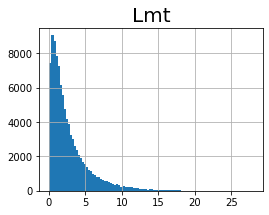

In [4]:
# plot raw_data histogram (for data pre-process / option-task)

## - parameter
# input : N1, N2, d1, d2, freq, move_tx, move_rx, offset_tx, offset_rx, per, space1, space2, space3, space4, l1, l2, h1, w1
# output : Lmt, Lmr, Llt, Llr, k, R1, R2

## - opt
# bins : (default : 100)
# plt_size : (default : [6,5])
# grid_en : (default : False)
# title_en : (default : False)
# title : (default : "")
# fontsize : (default : {}) (see : https://www.delftstack.com/ko/howto/matplotlib/how-to-set-the-figure-title-and-axes-labels-font-size-in-matplotlib/)

parameter = "Lmt" # desired parameter as a histogram
title = parameter # plot title name
fontsize = {'axes.titlesize' : 20, 'xtick.labelsize' : 10, 'ytick.labelsize' : 10}


plot_histogram(raw_data, parameter, plt_size=[4,3], grid_en=True, title_en=True, title=title, fontsize=fontsize)

In [5]:
## === dataset pre-processing ===

# drop output data except for target output

parameter = "Lmt" # target output pamareter
processed_data = drop_output(raw_data, parameter)



# cut data
## - opt
# lo : lower bound value (default : -inf)
# hi : upper bound value (default : inf)

processed_data = cut_data(processed_data, parameter="Lmt", lo=0.1, hi=10)



# add feature
# 기존에 존재하는 input parameter들을 이용해서 물리적인 의미를 갖는 새로운 파라미터를 만들어 낼 시 모델의 성능을 증가시킬 수 있음
# ex> 변압기 자화 인덕턴스는 턴수의 제곱에 비례하므로 턴수의 제곱에 해당하는 파라미터를 새로 만들어 자화인덕터 regression 모델을 만들 경우 모델 성능 증가

processed_data = add_feature(processed_data, parameter, new_feature_names = ["N1s"])



processed_data




,N1,N2,d1,d2,freq,move_tx,move_rx,offset_tx,offset_rx,per,space1,space2,space3,space4,l1,l2,h1,w1,Lmt,N1s
0,8,8,6.0,9.7,49000.0,2,5,7,-9,1480,1,23,3,55,19,41,166,24,0.240726,64.0
1,8,8,11.7,10.7,49000.0,6,4,18,-5,1160,5,47,3,31,31,72,251,248,2.028551,64.0
2,8,8,9.0,5.4,49000.0,4,1,9,-18,4192,5,31,7,28,33,40,191,212,8.913746,64.0
3,8,8,9.5,4.2,49000.0,6,3,14,-7,3419,1,21,6,38,15,30,185,221,4.010594,64.0
4,11,11,7.5,10.3,58000.0,1,2,13,-17,4445,7,50,6,46,16,69,207,241,8.989630,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95389,9,9,8.4,9.2,42000.0,7,2,8,-14,2483,9,59,9,35,30,71,235,105,2.362190,81.0
95390,5,5,11.4,8.9,25000.0,3,4,12,-6,1838,2,50,3,47,23,62,161,118,0.637322,25.0
95391,5,5,8.6,9.6,25000.0,2,2,17,-2,4913,1,21,3,35,29,51,110,80,1.872520,25.0
95392,5,5,11.0,3.6,25000.0,1,7,18,-12,4437,1,33,4,31,26,59,131,170,2.843685,25.0


In [6]:
# regression data

## - opt
# algorithm : regression algorithm (default : "ligthgbm")
# frac_ratio : train set / test set ratio (default : 0.9)
# silent : (default : True)
# save_en : whether to save the trained model as a file (.pkl) : (default : False)
# save_model_name : model file name : (default : "model")
# new_feature_names : to avoid number of features error (default : [])

## - algorithm list (see detail : https://pycaret.readthedocs.io/en/latest/api/regression.html)
# 'lr' - Linear Regression
# 'lasso' - Lasso Regression
# 'ridge' - Ridge Regression
# 'en' - Elastic Net
# 'lar' - Least Angle Regression
# 'llar' - Lasso Least Angle Regression
# 'omp' - Orthogonal Matching Pursuit
# 'br' - Bayesian Ridge
# 'ard' - Automatic Relevance Determination
# 'par' - Passive Aggressive Regressor
# 'ransac' - Random Sample Consensus
# 'tr' - TheilSen Regressor
# 'huber' - Huber Regressor
# 'kr' - Kernel Ridge
# 'svm' - Support Vector Regression
# 'knn' - K Neighbors Regressor
# 'dt' - Decision Tree Regressor
# 'rf' - Random Forest Regressor
# 'et' - Extra Trees Regressor
# 'ada' - AdaBoost Regressor
# 'gbr' - Gradient Boosting Regressor
# 'mlp' - MLP Regressor
# 'xgboost' - Extreme Gradient Boosting
# 'lightgbm' - Light Gradient Boosting Machine
# 'catboost' - CatBoost Regressor


[model, data_seen, data_unseen] = regression_basic(processed_data, parameter, algorithm="lightgbm", frac_ratio=0.9, save_en=False, save_model_name="model")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1340,0.0493,0.2221,0.9888,0.0547,0.0854
1,0.1361,0.0488,0.2208,0.9893,0.0561,0.0897
2,0.1321,0.0412,0.2031,0.9907,0.0533,0.0855
3,0.1370,0.0487,0.2206,0.9894,0.0565,0.0844
4,0.1346,0.0390,0.1974,0.9913,0.0514,0.0855
5,0.1357,0.0413,0.2031,0.9907,0.0559,0.0890
6,0.1385,0.0453,0.2128,0.9899,0.0532,0.0855
7,0.1404,0.0496,0.2226,0.9893,0.0561,0.0886
8,0.1374,0.0484,0.2201,0.9893,0.0556,0.0865
9,0.1386,0.0443,0.2105,0.9904,0.0519,0.0852


In [7]:
# verify model

verify_model(model, data_seen, data_unseen, parameter)

ValueError: Number of features of the model must match the input. Model n_features_ is 99 and input n_features is 19 